<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Neural_TLM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import warnings

import nltk
from nltk.corpus import stopwords
import re

from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Lambda, Concatenate, Reshape, Dot, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback

from gensim.models import Word2Vec

from matplotlib import pyplot as plt

TensorFlow 2.x selected.


In [2]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [4]:
thurs = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
leaves = nltk.corpus.gutenberg.raw('whitman-leaves.txt')
len(thurs), len(leaves)

(320525, 711215)

In [5]:
thurs = thurs.split('\n\n')
leaves = leaves.split('\n\n')
len(thurs), len(leaves)

(1304, 2867)

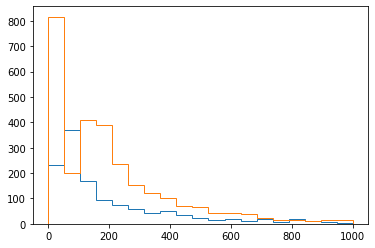

In [6]:
plt.hist([len(d) for d in thurs], bins=np.linspace(0,1000,20), histtype='step')
plt.hist([len(d) for d in leaves], bins=np.linspace(0,1000,20), histtype='step')
plt.show()

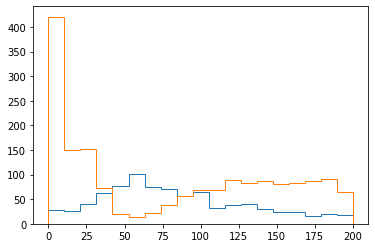

In [7]:
plt.hist([len(d) for d in thurs if len(d)<200], bins=np.linspace(0,200,20), histtype='step')
plt.hist([len(d) for d in leaves if len(d)<200], bins=np.linspace(0,200,20), histtype='step')
plt.show()

In [8]:
len([d for d in thurs if len(d)>50]), len([d for d in leaves if len(d)>50])

(1084, 2054)

In [0]:
texts = [d for d in thurs if len(d)>50]+[d for d in leaves if len(d)>50]

In [0]:
texts = [' '.join(d.split()) for d in texts]
texts = [d for d in texts if len(d)>50]

In [11]:
texts[10]

"The man with the meek blue eyes and the pale, pointed beard endured these thunders with a certain submissive solemnity. The third party of the group, Gregory's sister Rosamond, who had her brother's braids of red hair, but a kindlier face underneath them, laughed with such mixture of admiration and disapproval as she gave commonly to the family oracle."

In [0]:
sents = '\n'.join(texts)
sents = nltk.tokenize.sent_tokenize(sents)

In [0]:
def doc2words(doc):
  words = nltk.tokenize.word_tokenize(doc)
  words = [w.lower() for w in words if w.isalpha()]
  words = [w for w in words if (len(w)>1) and (w not in stopwords)]
  return words

In [0]:
sents = [doc2words(s) for s in sents]
sents = [s for s in sents if len(s)>0]

In [0]:
emb = Word2Vec(sents)

In [16]:
emb.wv.similar_by_word('door')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('without', 0.9998893737792969),
 ('great', 0.9998875260353088),
 ('life', 0.9998874068260193),
 ('vast', 0.9998844861984253),
 ('yet', 0.9998835325241089),
 ('war', 0.9998832941055298),
 ('like', 0.9998816251754761),
 ('upon', 0.9998815059661865),
 ('come', 0.9998805522918701),
 ('rest', 0.9998799562454224)]

In [0]:
we = {w:emb.wv.get_vector(w) for w in emb.wv.vocab}
vec_size = emb.vector_size

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class TLMDataGen:
  def __init__(self, documents, word_embedding, doc2words, lm_length, token2idx, vector_size,
               valid_num=None, valid_frac=None, batch_size=20, valid_batch_size=100):
    if valid_num is None and valid_frac is None:
      if len(documents) < 1000:
        valid_num = int(0.1*len(documents))
      else:
        valid_num = 100
    elif valid_num is None:
      valid_num = int(valid_frac*len(documents))

    perm = np.random.permutation(len(documents))
    self.train_idxs = perm[:valid_num]
    self.valid_idxs = perm[valid_num:]

    rep = {'<':'*', '>':'*'}
    rep = {re.escape(k):v for k,v in rep.items()}
    pattern = re.compile('|'.join(rep.keys()))

    self.documents = ['<'*lm_length+pattern.sub(lambda m: rep[re.escape(m.group(0))], d)+'>' for d in documents]
    self.batch_size = batch_size
    self.valid_batch_size = valid_batch_size
    self.word_embedding = word_embedding
    self.doc2words = doc2words
    self.lm_length = lm_length
    self.token2idx = token2idx
    self.vector_size = vector_size

  def get_train_batch(self):
    doc_idxs = np.random.choice(self.train_idxs, size=self.batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(self.lm_length+1, len(d)) for d in docs]
    
    x_topic = [np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]) for d in docs]
    x_topic = [d if d.shape != (0,) else np.zeros((1, self.vector_size)) for d in x_topic]
    x_topic = [d.mean(axis=0) for d in x_topic]
    x_topic = np.array(x_topic)

    lm_docs = [d[i-self.lm_length-1:i] for i, d in zip(finish_idxs, docs)]
    lm_docs = np.array([[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    return [x_topic, lm_docs[:,:-1]], lm_docs[:,1:]

  def get_valid_batch(self):
    doc_idxs = np.random.choice(self.valid_idxs, size=self.valid_batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(self.lm_length+1, len(d)) for d in docs]
    
    x_topic = [np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]) for d in docs]
    x_topic = [d if d.shape != (0,) else np.zeros((1, self.vector_size)) for d in x_topic]
    x_topic = [d.mean(axis=0) for d in x_topic]
    x_topic = np.array(x_topic)

    lm_docs = [d[i-self.lm_length-1:i] for i, d in zip(finish_idxs, docs)]
    lm_docs = np.array([[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    return [x_topic, lm_docs[:,:-1]], lm_docs[:,1:]


class TopicalLanguageModel:
  """
  Neural Topical Language Model.

  attributes:
  num_topics :: int : number of topics
  doc2words :: function : takes a document as a string and returns words
  word_embedding :: dict : keys are words, values are vectors
  vector_size :: int : the dimension of embedding vectors
  lm_length :: int : length of tokens taken into account for character-level language models 
  """
  def __init__(self, num_topics, word_embedding, vector_size, doc2words, lm_length=30, tokens='abcdefghijklmnopqrstuvwxyz '):
    self.num_topics = num_topics
    self.doc2words = doc2words
    self.word_embedding = word_embedding
    self.vector_size = vector_size
    self.lm_length = lm_length

    self.tokens = ['<', '>', '*'] + list(tokens)
    token_idx = [(t, k+3) for k,t in enumerate(list(tokens))]+[('<',0),('>',1),('*',2)]
    self.token2idx = {t:k for t,k in token_idx}
    self.idx2token = {k:t for t,k in token_idx}

    self.num_tokens = len(tokens)+3

  def fit(self, documents, batch_size=20, epochs=10, verbose=0, examples_per_epoch=5, example_epoch_skip=1, num_validation_samples=5):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    x_topic = Input(shape=(self.vector_size,))
    h_topic = Dense(self.vector_size, activation='relu')(x_topic)
    out_topic = Dense(self.num_topics, activation='softmax')(h_topic)
    self.topic_model = Model(inputs=[x_topic], outputs=out_topic)
    
    self.language_models = []
    for k in range(self.num_topics):
      x_lm = Input(shape=(self.lm_length,), dtype='int32')
      h_lm = Embedding(input_dim=self.num_tokens, output_dim=self.num_tokens//2, input_length=self.lm_length)(x_lm)
      h_lm = LSTM(self.num_tokens, return_sequences=True)(h_lm)
      h_lm = LSTM(self.num_tokens, return_sequences=True)(h_lm)
      out_lm = TimeDistributed(Dense(self.num_tokens, activation='softmax'))(h_lm)
      lm = Model(inputs=[x_lm], outputs=out_lm)
      self.language_models.append(lm)

    train_topic_input = Input(shape=(self.vector_size,))
    train_lm_input = Input(shape=(self.lm_length,), dtype='int32')

    lm_outputs = [Reshape(target_shape=(self.lm_length, self.num_tokens, 1))(lm(train_lm_input)) for lm in self.language_models]
    lm_outputs = Concatenate(axis=3)(lm_outputs)
    topic_mix = self.topic_model(train_topic_input)

    out = Dot(axes=(3, 1), name='mixed_out')([lm_outputs, topic_mix])

    self.train_model = Model(inputs=[train_topic_input, train_lm_input], outputs=[out, topic_mix])

    def mix_loss(y_true, y_pred):
      eps = 1e-10
      mean = K.mean(y_pred, axis=0)

      mean_nentropy = K.mean(K.sum(y_pred*K.log(y_pred+eps), axis=1))
      nentropy_mean = K.sum(mean*K.log(mean+eps))
      return nentropy_mean - mean_nentropy
      

    self.train_model.compile('adam', ['sparse_categorical_crossentropy', mix_loss])

    data_generator = TLMDataGen(documents, word_embedding=self.word_embedding, 
                                doc2words=self.doc2words, 
                                lm_length=self.lm_length, 
                                token2idx=self.token2idx,
                                vector_size=self.vector_size,
                                batch_size = batch_size)

    steps_per_epoch = len(documents)//batch_size
    self.logs = {'examples':[], 'val_loss':[], 'topic_fraction':[], 'topic_entropy':[]}
    for epoch in range(epochs+1):

      #examples
      if epoch%example_epoch_skip == 0:
        if verbose>1:
          print('Getting examples')
        for t in range(self.num_topics):
          for k in range(examples_per_epoch):
            self.logs['examples'].append((self.rollout('', topic=t, maxlen=100), t, epoch))

      #validation loss
      if verbose>1:
        print('Running validation loss')
      xs, y = data_generator.get_valid_batch()
      losses = [self.train_model.test_on_batch(xs, [y, np.zeros((y.shape[0], self.num_topics))]) for k in range(num_validation_samples)]
      self.logs['val_loss'].append(losses)

      #topics
      if verbose>1:
        print('Getting topic distributions')
      xs, y = data_generator.get_valid_batch()
      x = xs[0]
      topics = self.topic_model.predict(x)
      entropies = (-topics*np.log(topics)).sum(axis=1)
      mean_entropy = entropies.mean(axis=0)
      std_entropy = entropies.std(axis=0)
      mean_topics = topics.mean(axis=0)
      self.logs['topic_fraction'].append(mean_topics)
      self.logs['topic_entropy'].append((mean_entropy, std_entropy))

      if epoch<epochs:
        #train
        if verbose>1:
          print('Training')
        avg_loss = 0
        for step in range(steps_per_epoch):
          xs, y = data_generator.get_train_batch()
          avg_loss = (step/(step+1))*avg_loss + self.train_model.train_on_batch(xs, [y, np.zeros((y.shape[0], self.num_topics))])[0]/(step+1)
        #print
        if verbose > 0:
          if epoch%example_epoch_skip == 0:
            print('Epoch {0} - Avg train loss: {1:1.5f} - Sample: {2}'.format(epoch, avg_loss, self.logs['examples'][-1][0][:self.lm_length]))
          else:
            print('Epoch {0} - Avg train loss: {1}'.format(epoch, avg_loss))
      
  def predict(self, init_doc, topic, method='sample'):
    idx_doc = [self.token2idx.get(c,2) for c in init_doc]
    dlen = len(idx_doc)
    if dlen < self.lm_length:
      idx_doc = [0]*(self.lm_length-dlen)+idx_doc
    elif dlen > self.lm_length:
      idx_doc = idx_doc[-self.lm_length:]

    probs = self.language_models[topic].predict(np.array(idx_doc).reshape((1,-1)))[0,-1,:]

    if method == 'sample':
      return np.random.choice(self.tokens, p=probs)

    elif method == 'max':
      return self.tokens[np.argmax(probs)]

    elif method == 'distribution':
      return probs

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '>': break
      init_doc = init_doc + predicted

    return init_doc

  def get_topics(self, doc):
    words = self.doc2words(doc)
    embedding = np.array([self.word_embedding[w] for w in words if w in self.word_embedding]).mean(axis=0)
    return self.topic_model.predict(embedding.reshape((-1,1)))[0]

In [0]:
K.clear_session()
tlm = TopicalLanguageModel(num_topics=2, word_embedding=we, vector_size=vec_size, doc2words=doc2words, lm_length=40)

In [0]:
tlm.fit(texts, epochs=300, verbose=1, example_epoch_skip=1, examples_per_epoch=1)

Epoch 0 - Avg train loss: 2.83731 - Sample: pkna
Epoch 1 - Avg train loss: 2.53682 - Sample: p*a*uel*al*t*il***ik fi*ilwh*nan siw* **
Epoch 2 - Avg train loss: 2.33317 - Sample: r *ea *c  ec<*tgoea  hne mlui ocutldeh o
Epoch 3 - Avg train loss: 2.05266 - Sample: *<*arch mtdishtu  srh lc viloz iotinen*e
Epoch 4 - Avg train loss: 1.86163 - Sample: <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<* mofa
Epoch 5 - Avg train loss: 1.76716 - Sample: <*apud rahhesd it lon dninsksrnuors anea
Epoch 6 - Avg train loss: 1.66156 - Sample: <<<<<<<<<<<<<<<<<<<<<<<<<<<* warmtd*e ou
Epoch 7 - Avg train loss: 1.62274 - Sample: <<<<<<<<<* ssas fowin on vaf* ce fi wyed
Epoch 8 - Avg train loss: 1.57240 - Sample: <<<<<<*malosdtalesy* * wos ** sy rtesde 
Epoch 9 - Avg train loss: 1.50319 - Sample: <<<<<<<<<<<<<<<<<<<<<<<<<<* a laee lecs 
Epoch 10 - Avg train loss: 1.46995 - Sample: <<<<<<<<<<<<<<<<<<*** in * *ledhis hes t
Epoch 11 - Avg train loss: 1.43818 - Sample: <<<*** <g bacle myomros thalls* mndep sy
Epoch 12 - Avg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 34 - Avg train loss: 1.12903 - Sample: <<*hibltes a male* * feind* anm hais cra
Epoch 35 - Avg train loss: 1.12532 - Sample: <*hand and the chrusting exit moin is th
Epoch 36 - Avg train loss: 1.10902 - Sample: <*he a dinl*ting** *roy to he ellard the


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 37 - Avg train loss: 1.08793 - Sample: <<<<<<<<<<<<<<<<<<<<<<<<*he parsetipher 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 38 - Avg train loss: 1.07921 - Sample: * *are* * leads whaint srow the creat of


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 39 - Avg train loss: 1.08023 - Sample: <<<<<<<<<<**hlim of the dard* feal arthe
Epoch 40 - Avg train loss: 1.08402 - Sample: *o aw gollan and you * wupjistel fenly a
Epoch 41 - Avg train loss: 1.07090 - Sample: <<<<<<<<<<<<<<***s anrtile cisly* *or ti


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 42 - Avg train loss: 1.05541 - Sample: *enly*s mugher welpaos conest digm* ges 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 43 - Avg train loss: 1.04100 - Sample: <*he ladtacen he *adu* and roisk* *or an


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 44 - Avg train loss: 1.04321 - Sample: **sed siss* *ver ich a bad you undear* *


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 45 - Avg train loss: 1.03652 - Sample: <<<<<<<<<<<<* diar on dised mass halqy u


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 46 - Avg train loss: 1.00455 - Sample: <<<<<<<<<<<<<<<<<<*promhoton*s me* stor 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 47 - Avg train loss: 1.00814 - Sample: **s laon exit intingrester** *e *e on in


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 48 - Avg train loss: 0.98774 - Sample: <<*nd the badses he usmirard my sond** *
Epoch 49 - Avg train loss: 0.98283 - Sample: *ver and outge tull* the thare on* *he m


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 50 - Avg train loss: 0.98211 - Sample: <** *panging the basiliss and chiin trut


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 51 - Avg train loss: 0.97861 - Sample: *amerpan*dones* *he cosecarkcing and the
Epoch 52 - Avg train loss: 0.95358 - Sample: *ome and hard* hel ask the *o a youl* * 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 53 - Avg train loss: 0.95033 - Sample: <<<<<<<<*toht me stuswill ronted* *n *er


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 54 - Avg train loss: 0.93950 - Sample: <<*hor the reack* **ledy do *he wair* an


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 55 - Avg train loss: 0.92689 - Sample: <<<<<<<*naamy thing of hord**lle ywrmefs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 56 - Avg train loss: 0.95361 - Sample: * lin hend fhands and tacriln*s*e* an th


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 57 - Avg train loss: 0.93363 - Sample: *play and on the seeedvling* *r greather


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 58 - Avg train loss: 0.94221 - Sample: *omely and ore of anqy digh ase the dess


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 59 - Avg train loss: 0.91388 - Sample: **as leusf ase of malessoling me* *on bl


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 60 - Avg train loss: 0.90642 - Sample: <<<<**plasely eils eostill hellfous you 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 61 - Avg train loss: 0.91999 - Sample: <<<<**tss beery ravl* stron*d loy a butd


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 62 - Avg train loss: 0.88785 - Sample: <**wha daof maid a you joobser a darplin


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 63 - Avg train loss: 0.88362 - Sample: <<<<<**ld peame creathing the canting a 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 64 - Avg train loss: 0.86787 - Sample: <<<**pafian ry uny* doungfe* the mom and
Epoch 65 - Avg train loss: 0.86238 - Sample: <<<**t* said dister* **an a scandiby* se


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 66 - Avg train loss: 0.86597 - Sample: **that the your bid whand lravetoors and


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 67 - Avg train loss: 0.85866 - Sample: <*han gles* *r cones* of figrowed the no


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 68 - Avg train loss: 0.83513 - Sample: <<<* am man you swead* anguretre*her bei


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 69 - Avg train loss: 0.86833 - Sample: <<<<<<<<<<<<<<**rm hand conk** stribcses


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 70 - Avg train loss: 0.82774 - Sample: <*hfar ongings* *rvard*bt meaces* and tt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 71 - Avg train loss: 0.84402 - Sample: <<**f to wand ot one flugh fore wislom n


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 72 - Avg train loss: 0.81486 - Sample: <<* laad gifr farlfiness to ge trans* st


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 73 - Avg train loss: 0.79869 - Sample: <*s at dise meas poon * *hitimarentle* *


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 74 - Avg train loss: 0.80830 - Sample: <<<<<*faster* * uptull you ase yout havy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 75 - Avg train loss: 0.80565 - Sample: *merand he canphe**angs of syout sauster


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 76 - Avg train loss: 0.81019 - Sample: <<<<*l had dise *iclal and exord** bworp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 77 - Avg train loss: 0.79523 - Sample: <<*oor tile marveburitt as the but* *erc


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 78 - Avg train loss: 0.78041 - Sample: <<*oman you conme* *e tele charpble* **a


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 79 - Avg train loss: 0.78632 - Sample: *hard at heald* and ly the caressy dave 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 80 - Avg train loss: 0.78965 - Sample: <* loidronds* *areld benenine me* the to


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 81 - Avg train loss: 0.77982 - Sample: <**t a *anying the eacaten*on you your a


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 82 - Avg train loss: 0.75549 - Sample: **ls *orote of atdhinging pader*d har hy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 83 - Avg train loss: 0.76620 - Sample: <<<* worm pite* thed* inith had as sleet


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 84 - Avg train loss: 0.76158 - Sample: * and il *uvilbry under froes* *nd wiso 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 85 - Avg train loss: 0.73525 - Sample: <<<<<<<<<<<<<<<<<<<*he mad the usual tio


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 86 - Avg train loss: 0.73419 - Sample: <<<<<<<**stit easisl hairy sou tharfsaug


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 87 - Avg train loss: 0.74577 - Sample: <<* chanling foroibrery* and in toy defa


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 88 - Avg train loss: 0.73083 - Sample: <**ow * sa link* *ime on are the had as 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 89 - Avg train loss: 0.73470 - Sample: <***s ta barthw tack* the padn of oftach


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 90 - Avg train loss: 0.71541 - Sample: <<<*here at me chinls* **eres the lost m


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 91 - Avg train loss: 0.71498 - Sample: <<<<<<<* for hid of the strapmas* and ha


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 92 - Avg train loss: 0.72444 - Sample: *an ny so manging the moor* * weand buce


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 93 - Avg train loss: 0.71324 - Sample: *talt a loied refwithrophe* ecwirld to a


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 94 - Avg train loss: 0.69878 - Sample: *ar le* gise conmipe* **ilipres* * meaza


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 95 - Avg train loss: 0.71868 - Sample: *ndon noung on ed thot to dee* saud*d sw


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 96 - Avg train loss: 0.69866 - Sample: <<*all to do buidite one in there exinwi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 97 - Avg train loss: 0.71272 - Sample: * am ard brang* eeas* cot mang* *res* * 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 98 - Avg train loss: 0.70464 - Sample: <* east and gone and pover the hal of ou


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 99 - Avg train loss: 0.69160 - Sample: <<<<<<<<<<*oar of you waiyl the seeares 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 100 - Avg train loss: 0.67802 - Sample: **arhatuan you ranger* *he spulk* sturor


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 101 - Avg train loss: 0.68010 - Sample: <<* am ap planbing** vis of the bulls* *


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 102 - Avg train loss: 0.68156 - Sample: <<<<<<<<<<<<<*erank been in rosh flanger


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 103 - Avg train loss: 0.66697 - Sample: *he amn gone* *eapaces of neint over the


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 104 - Avg train loss: 0.64986 - Sample: *he allecher and on *e you colaly slefve


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 105 - Avg train loss: 0.65627 - Sample: <<**ot so so *e svad uplormlitt and and 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 106 - Avg train loss: 0.65784 - Sample: <<<<<<<<<<**ent a danding the hild and i


In [0]:
tlm.train_model.summary()

In [0]:
tlm.logs.keys()

In [0]:
pd.set_option('display.max_colwidth', -1)
ex = pd.DataFrame(columns=['example', 'topic_num', 'epoch'], data=tlm.logs['examples'])
ex.sample(50).sort_values('epoch')

In [0]:
len(tlm.logs['val_loss']), len(tlm.logs['val_loss'][0]), len(tlm.logs['val_loss'][0][0])

In [0]:
mean_losses = [np.array(v).mean(axis=0) for v in tlm.logs['val_loss']]
max_losses = [np.array(v).max(axis=0) for v in tlm.logs['val_loss']]
min_losses = [np.array(v).min(axis=0) for v in tlm.logs['val_loss']]
epoch = np.arange(len(mean_losses))

fig, axs = plt.subplots(3)
for k in range(3):
  axs[k].plot(epoch, [m[k] for m in mean_losses], color='b')
  axs[k].fill_between(epoch, [m[k] for m in max_losses], [m[k] for m in min_losses], color='b', alpha=0.3)
  axs[k].set_xlabel('Epoch')
  axs[k].set_ylabel('Loss: {}'.format(tlm.train_model.metrics_names[k]))

fig.set_size_inches(12,12)
plt.title('validation loss - max, mean, min')

plt.show()

In [0]:
epoch = np.arange(len(tlm.logs['topic_entropy']))

fig, ax_mean = plt.subplots()
ax_mean.stackplot(epoch, np.array(tlm.logs['topic_fraction']).T)
ax_mean.set_xlabel('Epoch')
ax_mean.set_ylabel('Topic Balance')

ax_ent = ax_mean.twinx()
topic_entropy = [e[0] for e in tlm.logs['topic_entropy']]
max_topic_entropy = [(-p*np.log(p)).sum() for p in tlm.logs['topic_fraction']]
frac_topic_entropy = [e/m for e,m in zip(topic_entropy, max_topic_entropy)]
ax_ent.plot(epoch, frac_topic_entropy, color='k')
ax_ent.set_ylabel('Topic entropy/max topic entropy (for given topic balance)')
ax_ent.set_ylim(0,1.05)

fig.set_size_inches(12,6)
fig.tight_layout()
plt.title('topic balance estimates - max, mean, min')

plt.show()